# Plots and analysis
This notebook contains plots and other code to explore guesses of the players of the game.

In [24]:
import math
import pandas as pd
import os
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


## Data

NB: Don't forget to run all the scripts prior to this step.

In [25]:
# Load all inputs
df_raw = pd.read_csv('../data/answers.csv',error_bad_lines=False)

#check
df_raw.shape

(23, 4)

In [26]:
df_raw.head()

,Timestamp,Current URL,Player,Guess
0,2021/01/14 11:20:26 PM GMT+1,URL11,Player1,Player2
1,2021/01/14 11:21:25 PM GMT+1,URL11,Player2,Player10
2,2021/01/14 11:21:45 PM GMT+1,URL11,Player7,Player1
3,2021/01/14 11:22:01 PM GMT+1,URL11,Player8,Player11
4,2021/01/14 11:22:21 PM GMT+1,URL11,Player6,Player1


In [27]:
#df_raw.shape

# which urls
urls = df_raw['Current URL'].unique()
print(urls.tolist())

# which players
players = df_raw['Player'].unique()

# which guesses
guess = df_raw['Guess'].unique()

['URL11', 'URL10', 'URL6']


In [28]:
# looking at the guesses per URL slice
df_url_guess=df_raw.loc[:,['Current URL','Guess']] #only guesses per URL
df_url_guess.head()

,Current URL,Guess
0,URL11,Player2
1,URL11,Player10
2,URL11,Player1
3,URL11,Player11
4,URL11,Player1


# Statistics
### Most popular and least votes

In [29]:
# code from https://towardsdatascience.com/from-dataframe-to-network-graph-bbb35c8ab675
# function creating leaderboard

def create_leaderboard(df,col_name, tab_header):
    leaderboard = df[col_name].value_counts(ascending=True)
    s = pd.Series(leaderboard, name=tab_header)
    df2 = s.to_frame().sort_values(tab_header, ascending=False)
    return df2

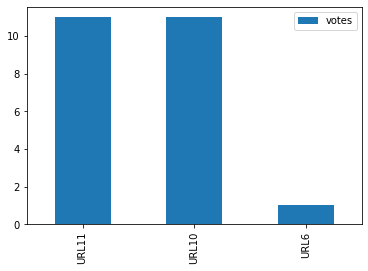

In [30]:
# total number of votes per link
votes_links = create_leaderboard(df_raw,'Current URL','votes')
votes_links.plot.bar(y='votes'); # plot histogram


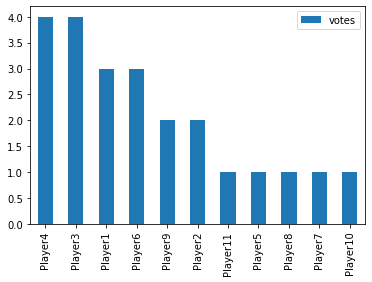

In [31]:
# total votes for each player

total_votes = create_leaderboard(df_raw,'Guess','votes')
total_votes.plot.bar(y='votes'); # plot histogram

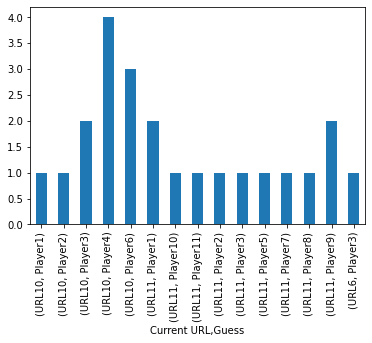

In [32]:
# stats of guesses per URL

guess_stats = df_raw.groupby(by=['Current URL', 'Guess'])['Guess'].count()
s = pd.Series(guess_stats, name="votes")
df_guess = s.to_frame().sort_values("votes", ascending=False).reset_index()
guess_stats.plot.bar(x='Current URL'); # plot histogram

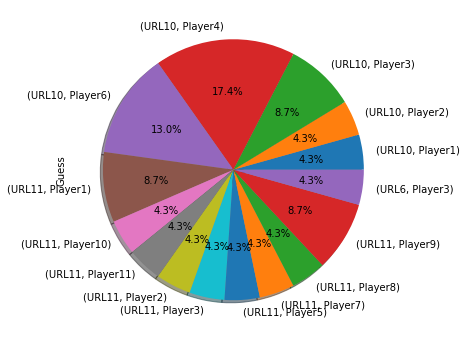

In [33]:
# combined pie chart
guess_stats.plot.pie(subplots=True,y='votes',figsize=(6, 6), autopct='%1.1f%%',shadow = True);

In [34]:
print(df_guess.columns)

Index(['Current URL', 'Guess', 'votes'], dtype='object')


In [35]:
df = df_guess.loc[df_guess['Current URL'] == 'URL6']
df.loc[:,['Guess','votes']]

,Guess,votes
14,Player3,1


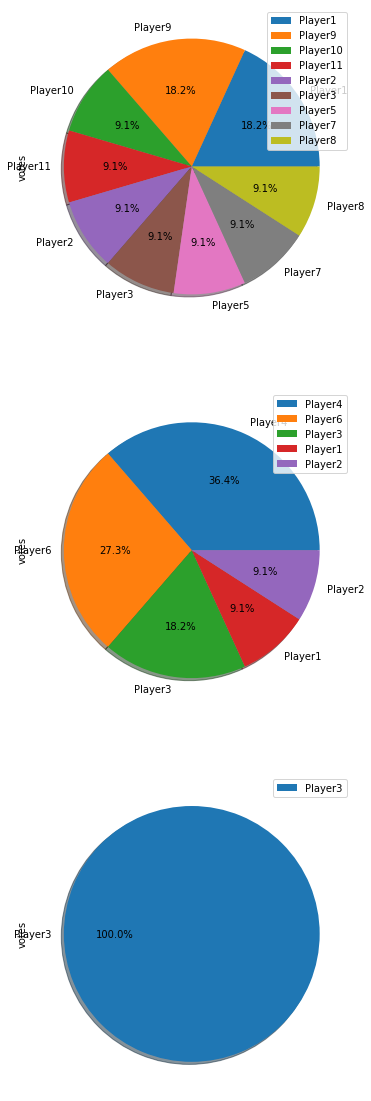

In [36]:
#pie chart per URL
#FIXME: legend placement

fig, axes = plt.subplots(len(urls),1,figsize=(30, 20)) #ncols=len(urls)#,)
#for i,ax in enumerate(axes):
for i,ax in enumerate(axes):
    url = urls[i]
    temp_df = df_guess.loc[df_guess['Current URL'] == url]
    temp_df.loc[:,['Guess','votes']].plot.pie(ax=ax,subplots=True,labels = temp_df['Guess'], y='votes', autopct='%1.1f%%',shadow = True);
plt.show()


# Appendix: Graphs

In [37]:
# first dumb graph, ignores weights
G = nx.from_pandas_edgelist(df_raw, 'Player', 'Guess',)

# and now we try multigraph
M = nx.from_pandas_edgelist(df_raw, 'Player', 'Guess', create_using=nx.MultiDiGraph())

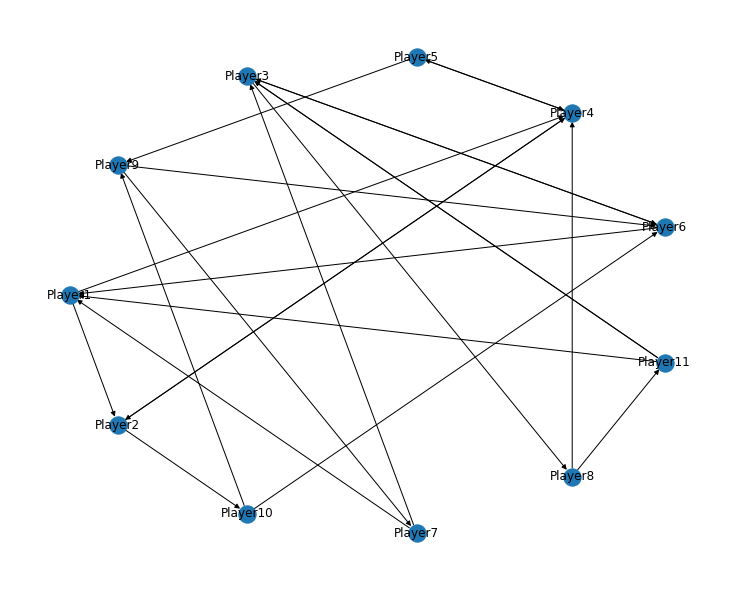

In [38]:
# plot spacy multigraph of who voted for whom
plt.figure(figsize=(10, 8))
nx.draw_shell(M, with_labels=True)

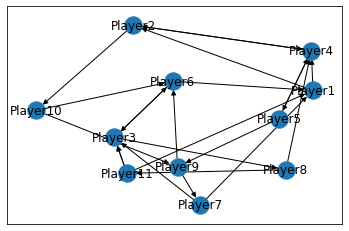

In [39]:
# a bit more dense
nx.draw_networkx(M)

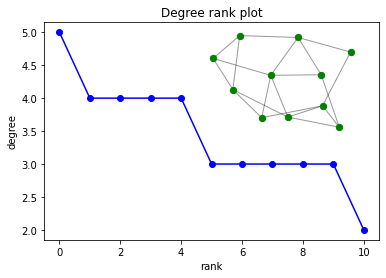

In [40]:
# another look via degree sequences
# source: from networkx gallery

degree_dist = sorted([vote for player, vote in G.degree()], reverse=True)
dmax = max(degree_dist)

plt.plot(degree_dist, "b-", marker="o")
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

# draw graph in inset
# not implemented for directed graph?
plt.axes([0.5, 0.5, 0.35, 0.35])
g_cc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=False)[0])
pos = nx.spring_layout(g_cc)
plt.axis("off")
nx.draw_networkx_nodes(g_cc, pos, node_size=40, node_color="green")
nx.draw_networkx_edges(g_cc, pos, arrowstyle="->", arrowsize=10, alpha=0.4)